In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, assemble, execute
from qiskit.visualization import plot_histogram
import matplotlib as plt
import numpy as np
import torch
from torch.autograd import Variable

In [2]:
# constants for the structure of the circuit
number_of_qubits = 1
number_of_layers = 1

In [3]:
# input and target states initialization

initial_state = [1,0]

target_state = Variable(
    torch.tensor([1,1]/np.sqrt(2)),
    requires_grad=False
)

In [4]:
params = np.random.normal(0, np.pi, (number_of_qubits, number_of_layers, 3))
params = torch.tensor(params)#, requires_grad=True

In [5]:
# function that creates and runs the circuit with fixed parameters

def evaluate_circuit(params, _initial_state):
    
    # circuit initialization
    qr = QuantumRegister(number_of_qubits)
    cr = ClassicalRegister(number_of_qubits)

    circuit = QuantumCircuit(qr, cr)

    #circuit.initialize(_initial_state)
    circuit.barrier()
    
    # layers definition
    for j in range(number_of_layers):
        for i in range(number_of_qubits):
            circuit.rx(params[i, j, 0].item(), i)
            circuit.ry(params[i, j, 1].item(), i)
            circuit.rz(params[i, j, 2].item(), i)
            
            for k in range(i+1, number_of_qubits):
                circuit.cx(i, k)

            circuit.barrier()
    
    
    #for i in range(number_of_qubits):
        #circuit.measure(i, i)

    return circuit

In [6]:
# function to retrive the uotput state amplitudes

def get_amplitudes(circuit):
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    amplitudes = job.result().get_statevector(circuit)
    
    return amplitudes

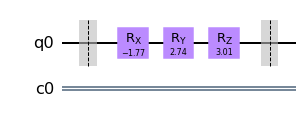

In [7]:
circuit = evaluate_circuit(params, initial_state)
circuit.draw(output='mpl')

In [8]:
get_amplitudes(circuit)

array([-0.74858757-0.17485466j, -0.11386961+0.62934586j])

In [9]:
# starting with linear cost function, minimize the difference between each amplitude
def amplitudes_cost(params_):
    cost = 0.
    amplitudes = get_amplitudes(evaluate_circuit(params_, initial_state))
    for k in range(len(amplitudes)):
        cost += torch.abs(amplitudes[k] - target_state[k])

    return cost

In [10]:
amplitudes_cost(params).item()

2.50060427043723

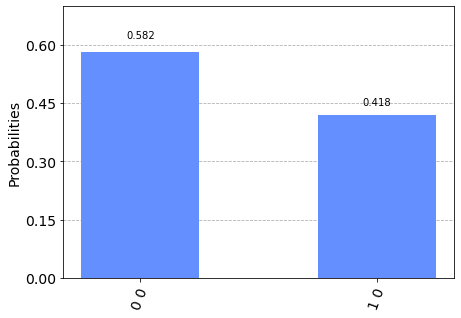

In [11]:
circuit.measure_all()

aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(circuit, shots=1000)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

In [13]:

# set up the optimizer
opt = torch.optim.Adam([params], lr=0.1)

# number of steps in the optimization routine
steps = 200

# the final stage of optimization isn't always the best, so we keep track of
# the best parameters along the way
best_cost = amplitudes_cost(params)
best_params = np.zeros((number_of_qubits, number_of_layers, 3))

print("Cost after 0 steps is {:.4f}".format(amplitudes_cost(params)))

# optimization begins
for n in range(steps):
    opt.zero_grad()
    loss = amplitudes_cost(params)
    loss.backward()
    opt.step()

    # keeps track of best parameters
    if loss < best_cost:
        best_cost = loss
        best_params = params

    # Keep track of progress every 10 steps
    if n % 10 == 9 or n == steps - 1:
        print("Cost after {} steps is {:.4f}".format(n + 1, loss))

# calculate the Bloch vector of the output state
output_state = get_amplitudes(evaluate_circuit(best_params, initial_state))

# print results
print("Target vector = ", target_state)
print("Output vector = ", output_state)

Cost after 0 steps is 2.5006


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
import torch
opt = torch.optim.Adam([torch.tensor(params)], lr=0.1)

In [ ]:
print(amplitudes_cost(params))